### Load data

In [1]:
import common
import pandas as pd
common.load_clts()
data_df, lects_df = common.load_lexirumah()
display(data_df.head())
display(lects_df.head())




FileNotFoundError: [Errno 2] No such file or directory: '/home/peter/git/agents-social/clts-1.4.1/pkg/transcriptionsystems'

### Select and combine data

In [2]:
#lects_df = lects_df[["ID", "Name", "Family", "Region", "Latitude", "Longitude"]]
# Filter out proto-languages
lects_df = lects_df[~lects_df["Name"].str.startswith("proto-")]
lects_alorese = lects_df[lects_df["Name"].str.startswith("Alorese")]
# Four Western Lamaholot languages close to Alorese
#lects_lamaholot_related = lects_df[lects_df["Name"].str.contains(
#    "Lamalera|Lewotobi|Lewoingu|Lewolema", case=False, regex=True)]
lects_western_lamaholot = lects_df[lects_df["Iso"].isin(["adr", "lmr", "slp", "ila", "lwt"])]
# Flores-Lembata family, but with preceding WL varieties excluded (and Alorese excluded)
lects_flores_lembata = lects_df[(lects_df["ID"].str.startswith("lama") | lects_df["ID"].str.startswith("sika") | lects_df["ID"].str.startswith("keda")) & ~lects_df.index.isin(lects_western_lamaholot.index)]
# Timor-Alor-Pantar languages, but only Alor-Pantar languages, spoken adjacent to Alorese
lects_alor_pantar = lects_df[lects_df["Family"].str.startswith("Timor-Alor-Pantar") & lects_df["Region"].str.contains("Alor|Pantar", case=False, regex=True)]
# Other Timor-Alor-Pantor languages, spoken on Timor (and small island Kisar)
lects_timor = lects_df[lects_df["Family"].str.startswith("Timor-Alor-Pantar") & ~lects_df.index.isin(lects_alor_pantar.index)]
lects_selected_df = pd.concat([lects_alorese, lects_western_lamaholot, lects_flores_lembata, lects_alor_pantar, lects_timor])

# Join data with lect name from lects table
# This order (first select lects, then merge) fastest
data_langs_df = data_df[data_df["Lect_ID"].isin(lects_selected_df["ID"])]
data_langs_df = data_langs_df.rename(columns={"ID":"Form_ID"})
data_merged_df = data_langs_df.merge(lects_df, how="left", left_on="Lect_ID", right_on="ID")
data_merged_df = data_merged_df.drop("ID", axis=1)
display(data_merged_df.head())


,Form_ID,Lect_ID,Concept_ID,Form_according_to_Source,Form,Local_Orthography,Segments,Comment_x,Source,Name,...,Latitude,Longitude,Region,Glottocode,Iso,Culture,Description,Orthography,Comment_y,Macroarea
0,abui1241-fuime-sky-1,abui1241-fuime,sky,adi,adi,adi,"[a, d, i]",None,[schapper10],"Abui, Fuimelang",...,-8.236,124.6783,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,None,None,"[p/general, p/abui1241-fuime]",None,Papunesia
1,abui1241-fuime-sun-1,abui1241-fuime,sun,wari,wari,wari,"[w, a, r, i]",None,[schapper10],"Abui, Fuimelang",...,-8.236,124.6783,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,None,None,"[p/general, p/abui1241-fuime]",None,Papunesia
2,abui1241-fuime-moon-1,abui1241-fuime,moon,ije,ije,iye,"[i, j, e]",None,[schapper10],"Abui, Fuimelang",...,-8.236,124.6783,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,None,None,"[p/general, p/abui1241-fuime]",None,Papunesia
3,abui1241-fuime-star-1,abui1241-fuime,star,fɪri,fɪri,firi,"[f, ɪ, r, i]",None,[schapper10],"Abui, Fuimelang",...,-8.236,124.6783,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,None,None,"[p/general, p/abui1241-fuime]",None,Papunesia
4,abui1241-fuime-night-1,abui1241-fuime,night,tuŋtama,tuŋtama,tungtama,"[t, u, ŋ, t, a, m, a]",None,[schapper10],"Abui, Fuimelang",...,-8.236,124.6783,"Kecamatan Perwakilan Alor Barat Laut, Kabupate...",abui1241,abz,None,None,"[p/general, p/abui1241-fuime]",None,Papunesia


### Compute phoneme distributions & compute feature matrix per language

In [5]:
#display(data_merged_df[data_merged_df["Lect_ID"]=="alor1247-baran"])
CHARACTER_SEGMENTATION = False
if CHARACTER_SEGMENTATION:
    # perform per-character segmentation
    data_merged_df["Segments_char"] = data_merged_df["Form"].apply(list) # lambda x : [el for el in x if el!="_"]
    segments_col = "Segments_char"
    display(data_merged_df[["Segments", "Segments_char"]].sample(n=50, random_state=24))
else:
    # Use segmentation from dataset (clustering some combinations together)
    segments_col = "Segments_norm"
    #data_merged_df["Segments_norm"] = data_merged_df["Segments"].apply(lambda x : common.normalize_list(x, method="ipapy", ud_form="NFD"))
    data_merged_df["Segments_norm"] = data_merged_df["Segments"].apply(lambda x : x)
    display(data_merged_df[["Segments", "Segments_norm"]].sample(n=50, random_state=24))

data_grouped_lang = data_merged_df.groupby("Lect_ID")
data_agg = data_grouped_lang.aggregate({segments_col:list, "Name": "first", "Family": "first", "Latitude": "first", "Longitude":"first"})
# data_agg["phone_prob"] = data_agg[segments_col].apply(common.phone_prob)
# data_agg["biphone_prob"] = data_agg[segments_col].apply(common.biphone_prob)
# data_agg["phone_prob_existence"] = data_agg[segments_col].apply(common.phone_prob_existence)
# data_agg["biphone_prob_existence"] = data_agg[segments_col].apply(common.biphone_prob_existence)
# display(data_agg.head())

# Effect now is:
# -1 for available biphone,
# -None for combination not available, None for combination and both constitutents not available
# => None replaced by 0
# What Macklin-Cordes does:
# - 1 for available biphone
# - 0 for combination not available, if constituents are available
# - None for combination not available, if constituents not available
phone_prob_matrix = common.create_matrix(data_agg, segments_col, common.phone_prob, "phone_prob")
phone_prob_existence_matrix = common.create_matrix(data_agg, segments_col, common.phone_prob_existence, "phone_prob_existence")
biphone_prob_matrix = common.create_matrix(data_agg, segments_col, common.biphone_prob, "biphone_prob")
biphone_prob_existence_matrix = common.create_matrix(data_agg, segments_col, common.biphone_prob_existence, "biphone_prob_existence")

phone_prob_boundaries_matrix = common.create_matrix(data_agg, segments_col, common.phone_prob_boundaries, "phone_prob_boundaries")
biphone_transition_matrix = common.create_biphone_transition_matrix(biphone_prob_matrix, phone_prob_boundaries_matrix)

display(phone_prob_matrix.head())
display(phone_prob_existence_matrix.head())
display(biphone_prob_matrix.head())
display(biphone_prob_existence_matrix.head())
display(biphone_transition_matrix.head())


,Segments,Segments_norm
12220,"[b, aː, t, _, t, a, f, e]","[b, aː, t, _, t, a, f, e]"
29386,"[p, u, l, u, _, ʋ, o, t, _, t, ə, l, u]","[p, u, l, u, _, ʋ, o, t, _, t, ə, l, u]"
26412,"[n, a, ʔ, ɪ, r, o, b, a]","[n, a, ʔ, ɪ, r, o, b, a]"
10544,"[s, a, j, u, r, a]","[s, a, j, u, r, a]"
8206,"[h, i, n, ɑ, l]","[h, i, n, ɑ, l]"
8809,"[ʔ, i, k, ɑ, n]","[ʔ, i, k, ɑ, n]"
41468,"[k, a, nː, a, k, u, ŋ]","[k, a, nː, a, k, u, ŋ]"
6263,"[o, s, o, ŋ]","[o, s, o, ŋ]"
33828,"[a, m, i, n, a]","[a, m, i, n, a]"
2455,"[k, a, f, e]","[k, a, f, e]"


,aː,ó,u̘,x,pː,ĩ,ɛ,ə̃,mː,kʷ,...,ɑː,ṳ,á,ũː,ĩː,z,tː,ɞ,ɑ,tɕ
Lect_ID,,,,,,,,,,,,,,,,,,,,,
abui1241-fuime,0.00895522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abui1241-papun,0.0286006,NaN,NaN,NaN,NaN,NaN,0.0383044,NaN,NaN,0.000510725,...,0.000510725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.166496,NaN
abui1241-petle,0.00996016,NaN,NaN,NaN,NaN,NaN,0.00199203,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abui1241-takal,0.000239521,NaN,NaN,NaN,NaN,0.000239521,NaN,NaN,NaN,0.000239521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000479042,0.000239521,NaN
abui1241-ulaga,0.0180488,NaN,NaN,NaN,NaN,NaN,0.000731707,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,aː,ó,u̘,x,pː,ĩ,ɛ,ə̃,mː,kʷ,...,ɑː,ṳ,á,ũː,ĩː,z,tː,ɞ,ɑ,tɕ
Lect_ID,,,,,,,,,,,,,,,,,,,,,
abui1241-fuime,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abui1241-papun,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
abui1241-petle,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abui1241-takal,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN
abui1241-ulaga,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,k,mː,ɛ,a,k,m,ɔ,eː,ɘ,ɛ,...,p,ɔ,ɜ,tʃ,e,d,🡄,aː̈,i,eː
,ɤː,o,ɲ,g,ø,ɛ̃ː,j,n,m,h,...,ũ,lˑ,b,a,ʋ,o,ɰ,m,ã,s
Lect_ID,,,,,,,,,,,,,,,,,,,,,
abui1241-fuime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abui1241-papun,NaN,NaN,NaN,0.000866551,NaN,NaN,NaN,0.000433276,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000433276
abui1241-petle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abui1241-takal,NaN,NaN,NaN,NaN,NaN,NaN,0.000416493,NaN,0.000208247,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00062474,0.000208247,NaN
abui1241-ulaga,NaN,NaN,NaN,0.00104406,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000208812,NaN,0.00125287,NaN,NaN,NaN,0.000208812


,k,mː,ɛ,a,k,m,ɔ,eː,ɘ,ɛ,...,p,ɔ,ɜ,tʃ,e,d,🡄,aː̈,i,eː
,ɤː,o,ɲ,g,ø,ɛ̃ː,j,n,m,h,...,ũ,lˑ,b,a,ʋ,o,ɰ,m,ã,s
Lect_ID,,,,,,,,,,,,,,,,,,,,,
abui1241-fuime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abui1241-papun,NaN,NaN,NaN,1,NaN,NaN,NaN,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
abui1241-petle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abui1241-takal,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN
abui1241-ulaga,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,1


,k,mː,ɛ,a,k,m,ɔ,eː,ɘ,ɛ,...,🔙p,🔙ɔ,🔙ɜ,🔙tʃ,🔙e,🔙d,🔙🡄,🔙aː̈,🔙i,🔙eː
,ɤː,o,ɲ,g,ø,ɛ̃ː,j,n,m,h,...,🔙ũ,🔙lˑ,🔙b,🔙a,🔙ʋ,🔙o,🔙ɰ,🔙m,🔙ã,🔙s
Lect_ID,,,,,,,,,,,,,,,,,,,,,
abui1241-fuime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abui1241-papun,NaN,NaN,NaN,0.255921,NaN,NaN,NaN,0.115165,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0171888
abui1241-petle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abui1241-takal,NaN,NaN,NaN,NaN,NaN,NaN,0.0196621,NaN,1.13057,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022917,0.113057,NaN
abui1241-ulaga,NaN,NaN,NaN,0.00761565,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.00152313,NaN,0.0571936,NaN,NaN,NaN,0.017598


### Perform dimensionality reduction

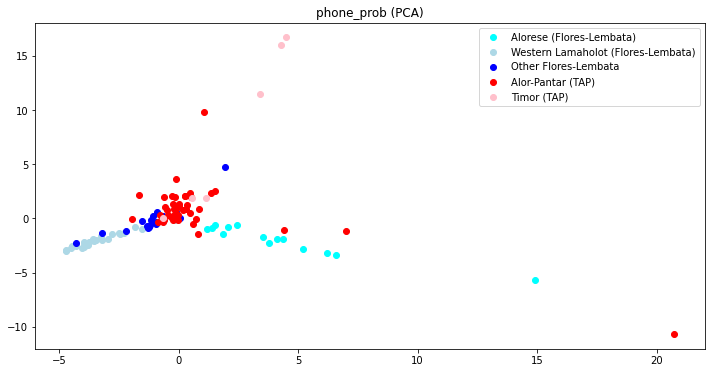

Loadings positive x:


kː    0.231727
nː    0.229743
tː    0.229180
bː    0.228419
mː    0.224324
pː    0.216608
lː    0.210351
dː    0.201428
gː    0.179173
sː    0.164911
Name: PC1, dtype: float64

Loadings negative x:
o     -0.155826
ã    -0.145686
ə     -0.142888
õ    -0.140334
ũ    -0.136783
ẽ    -0.123282
ĩ    -0.110461
ãː   -0.099997
e     -0.096619
ũː   -0.096095
Name: PC1, dtype: float64
Loadings positive y:


tʰ    0.216343
kʰ    0.214205
pʰ    0.213825
z     0.202750
aˑ    0.200249
iˑ    0.200249
k̚    0.200249
lˑ    0.200249
ts    0.184010
tʃ    0.183000
Name: PC2, dtype: float64

Loadings negative y:


p    -0.147324
kː   -0.122875
e    -0.122514
bː   -0.121540
nː   -0.118896
pː   -0.116329
tː   -0.115700
lː   -0.114253
mː   -0.112910
a    -0.110897
Name: PC2, dtype: float64

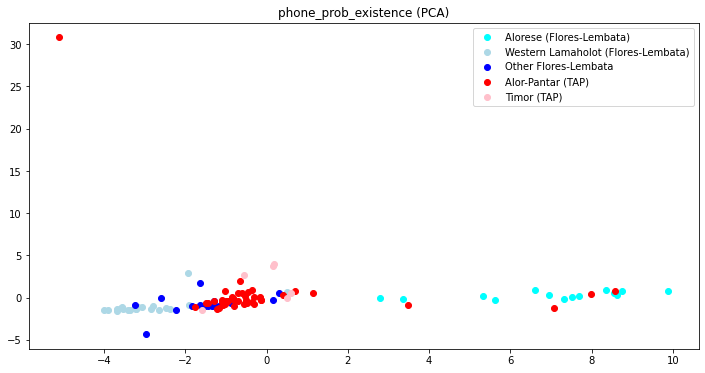

Loadings positive x:


nː    0.261316
bː    0.260438
pː    0.256570
kː    0.255466
rː    0.252140
lː    0.249344
mː    0.247299
dː    0.242461
tː    0.242013
gː    0.190871
Name: PC1, dtype: float64

Loadings negative x:
õ    -0.135218
ẽ    -0.130242
ã    -0.113607
ɲ     -0.102439
oː    -0.100256
ũ    -0.097368
ãː   -0.097266
ə̃    -0.081075
ĩ    -0.075816
ũː   -0.072321
Name: PC1, dtype: float64
Loadings positive y:


ɐ      0.289685
e̞ː    0.289685
ä     0.289685
e̞     0.289685
ɘ      0.289685
ü     0.289685
aː̈    0.289685
ɞ      0.289685
ɪ̈     0.289685
tʰ     0.176848
Name: PC2, dtype: float64

Loadings negative y:


õ    -0.051548
ẽ    -0.047826
ũ    -0.044118
ɔ̘    -0.040421
æ̘    -0.040421
ɛ̘    -0.040421
i̘    -0.040421
a̘    -0.040421
u̘    -0.040421
ãː   -0.039437
Name: PC2, dtype: float64

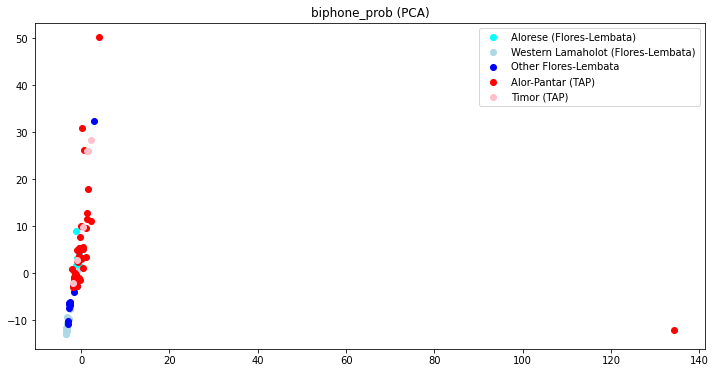

Loadings positive x:


f    aː̈    0.074489
r    ä     0.074489
q    ɔ      0.074489
aː̈  t      0.074489
e̞   r      0.074489
aː̈  ŋ      0.074489
e̞   d      0.074489
m    j      0.074489
ʋ    e̞     0.074489
e̞   ŋ      0.074489
Name: PC1, dtype: float64

Loadings negative x:
r  a   -0.021399
m  a   -0.021194
a  t   -0.020596
   🡆   -0.018868
b  a   -0.018600
l  e   -0.018028
n  a   -0.017459
m  e   -0.016605
e  🡆   -0.016511
b  e   -0.016432
Name: PC1, dtype: float64
Loadings positive y:


ɛ  s     0.064035
   g     0.061267
   n     0.060838
   l     0.060705
m  ɛ     0.060039
b  ɛ     0.059258
t  ɛ     0.059192
ɛ  b     0.056298
ɑ  k     0.055796
g  iː    0.055256
Name: PC2, dtype: float64

Loadings negative y:


e  🡆   -0.057075
p  e   -0.056769
o  🡆   -0.054377
p  i   -0.053829
🡄  p   -0.052964
m  e   -0.052913
b  e   -0.052803
   ə   -0.052215
ŋ  e   -0.050548
e  l   -0.050397
Name: PC2, dtype: float64

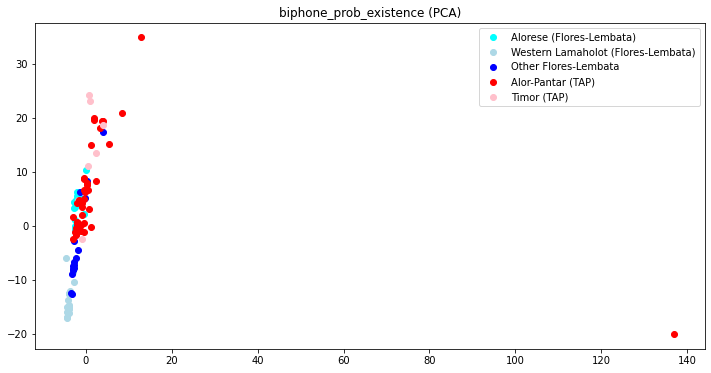

Loadings positive x:


t   e̞ː    0.071078
r   aː̈    0.071078
🡄   ä     0.071078
e̞  n      0.071078
    b      0.071078
m   ɞ      0.071078
ä  d      0.071078
l   ɐ      0.071078
ä  _      0.071078
p   ä     0.071078
Name: PC1, dtype: float64

Loadings negative x:
a  r   -0.071078
🡄  a   -0.071078
m  a   -0.053655
a  n   -0.053655
t  a   -0.047888
k  a   -0.047888
a  l   -0.047888
l  a   -0.045670
r  a   -0.043111
a  m   -0.043111
Name: PC1, dtype: float64
Loadings positive y:


r  ɛ    0.059925
t  ɛ    0.058939
ɛ  l    0.058573
_  s    0.058225
b  ɛ    0.057937
n  ɛ    0.057779
l  ɛ    0.056667
ɛ  k    0.055667
   t    0.055637
   🡆    0.055446
Name: PC2, dtype: float64

Loadings negative y:


l   ã   -0.061994
ã  🡆    -0.060694
n   ã   -0.059744
r   õ   -0.059601
õ  🡆    -0.058849
k   ã   -0.058410
ŋ   e    -0.057704
w   ã   -0.057588
r   ã   -0.057409
ʔ   ã   -0.056778
Name: PC2, dtype: float64

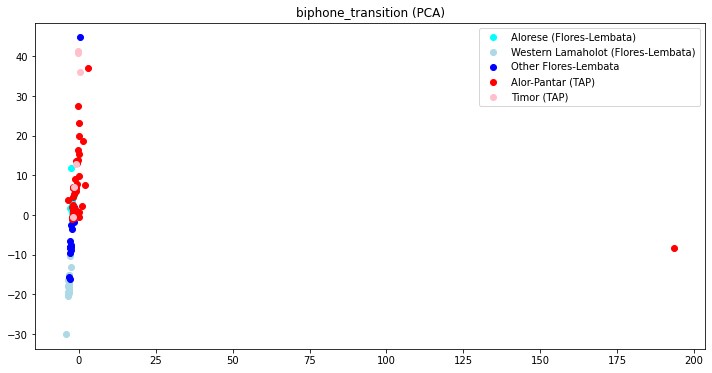

Loadings positive x:


🔙m    🔙e̞    0.052158
e̞    q      0.052158
aː̈   🡆      0.052158
      q      0.052158
ä    t      0.052158
🔙q    🔙d     0.052158
s     ä     0.052158
🔙aː̈  🔙n     0.052158
aː̈   _      0.052158
j     e̞     0.052158
Name: PC1, dtype: float64

Loadings negative x:
🔙m  🔙a   -0.020698
m   a    -0.015433
🔙l  🔙a   -0.015109
b   a    -0.014783
r   a    -0.014770
🔙a  🔙t   -0.014649
n   a    -0.014335
🔙t  🔙a   -0.013917
🔙r  🔙a   -0.013677
a   m    -0.013410
Name: PC1, dtype: float64
Loadings positive y:


🔙ɛ  🔙n    0.049524
    🔙l    0.046227
t   ɛ     0.045336
🔙ɛ  🔙k    0.044021
🔙ɔ  🔙k    0.043957
🔙l  🔙🡆    0.043667
l   🡆     0.043593
🔙ɔ  🔙l    0.043387
m   ɛ     0.042682
n   _     0.042495
Name: PC2, dtype: float64

Loadings negative y:


🔙e  🔙🡆   -0.046226
õ  🡆    -0.045698
l   o    -0.045593
🔙e  🔙l   -0.045478
a   o    -0.045477
🔙ə  🔙r   -0.045271
🔙ŋ  🔙e   -0.045270
🔙p  🔙i   -0.045216
ã  🡆    -0.045119
🔙o  🔙🡆   -0.045102
Name: PC2, dtype: float64

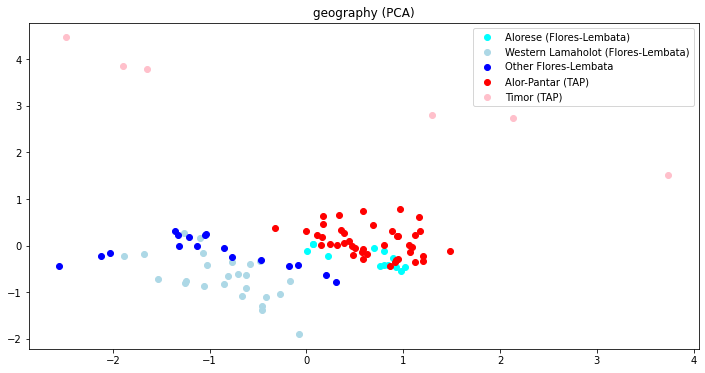

Loadings positive x:


Latitude     0.707107
Longitude    0.707107
Name: PC1, dtype: float64

Loadings negative x:
Longitude    0.707107
Latitude     0.707107
Name: PC1, dtype: float64
Loadings positive y:


Longitude    0.707107
Latitude    -0.707107
Name: PC2, dtype: float64

Loadings negative y:


Latitude    -0.707107
Longitude    0.707107
Name: PC2, dtype: float64

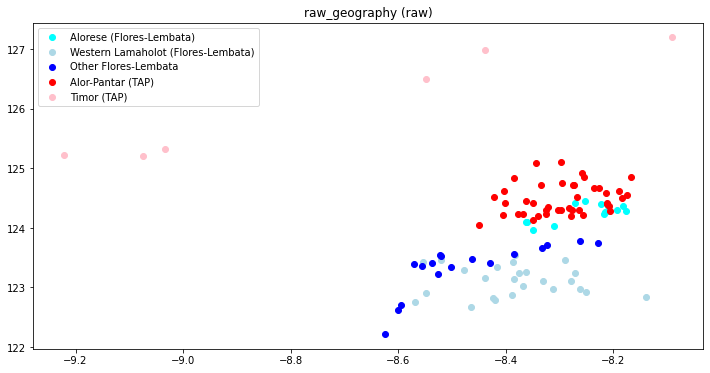

In [25]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

PLOT_LABELS = False

# TODO: Biphone prob with transition probabilities

# Define language groups for plots
language_groups = {"Alorese (Flores-Lembata)": {"color": "cyan", "lects": lects_alorese["ID"]},
                   "Western Lamaholot (Flores-Lembata)": {"color": "lightblue", "lects": lects_western_lamaholot["ID"]},
                   "Other Flores-Lembata": {"color": "blue", "lects": lects_flores_lembata["ID"]},
                   "Alor-Pantar (TAP)": {"color": "red", "lects": lects_alor_pantar["ID"]},
                   "Timor (TAP)": {"color": "pink", "lects": lects_timor["ID"]}
                  }

dim_reds_available = {"PCA": PCA(n_components=2)}#,"MDS": MDS()}

analyses = {"phone_prob": phone_prob_matrix,
            "phone_prob_existence": phone_prob_existence_matrix,
            "biphone_prob": biphone_prob_matrix,
            "biphone_prob_existence": biphone_prob_existence_matrix,
            "biphone_transition": biphone_transition_matrix,
            "geography": data_agg[["Latitude", "Longitude"]].fillna(0),
            "raw_geography": ["Latitude", "Longitude"],
            }

for study_label, study_data in analyses.items():
    if study_label == "raw_geography":
        reduce = False
        plot_cols = study_data
        dim_reds = {"raw": plot_cols}
    else:
        reduce = True
        dim_reds = dim_reds_available
    for dr_label, dr in dim_reds.items():
        common.reduce_plot(study_label, study_data, dr_label, dr, data_agg, language_groups, PLOT_LABELS, reduce)
        if dr_label == "PCA":
            loadings_x_pos, loadings_x_neg, loadings_y_pos, loadings_y_neg = common.compute_loadings(dr, study_data.columns)
            print("Loadings positive x:")
            display(loadings_x_pos)
            print("Loadings negative x:")
            display(loadings_x_neg)
            print("Loadings positive y:")
            display(loadings_y_pos)
            print("Loadings negative y:")
            display(loadings_y_neg)
        